# Economic Viability Analysis

# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import pickle
import os
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [2]:
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option("display.width",None)
pd.set_option("display.float_format","{:.2f}".format)

In [4]:
RAW_DATA_PATH = '../data/raw/'
PROCESSED_PATH = '../data/processed/'
RESULTS_PATH = '../data/results/'
VIZ_PATH = '../data/visualizations/'
MODELS_PATH = '../models/'

In [5]:
for path in [PROCESSED_PATH, RESULTS_PATH, VIZ_PATH, MODELS_PATH]:
    os.makedirs(path, exist_ok=True)

print("Setup complete!")

Setup complete!


# 2.  Load All Data Sources

In [6]:
crop_data_path=RAW_DATA_PATH+"Crop_recommendation.csv"

In [7]:
try:
    crop_df=pd.read_csv(crop_data_path)
    print("Crop data loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file at {crop_data_path} was not found.")
    crop_df=None

if crop_df is not None:
    print("First few rows of the dataset:")
    display(crop_df.head())
    print("\nDataset Info:")
    crop_df.info()
    print("\nStatistical Summary:")
    display(crop_df.describe())
    
    unique_crops = crop_df['label'].unique()
    print(f"\nUnique Crops ({len(unique_crops)}):")
    for i,crop in enumerate(sorted(unique_crops),1):
        count=len(crop_df[crop_df['label']==crop])
        print(f"{i}. {crop} - {count} entries")

Crop data loaded successfully.
First few rows of the dataset:


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.88,82.00,6.50,202.94,rice
1,85,58,41,21.77,80.32,7.04,226.66,rice
2,60,55,44,23.00,82.32,7.84,263.96,rice
3,74,35,40,26.49,80.16,6.98,242.86,rice
4,78,42,42,20.13,81.60,7.63,262.72,rice



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB

Statistical Summary:


,N,P,K,temperature,humidity,ph,rainfall
count,2200.00,2200.00,2200.00,2200.00,2200.00,2200.00,2200.00
mean,50.55,53.36,48.15,25.62,71.48,6.47,103.46
std,36.92,32.99,50.65,5.06,22.26,0.77,54.96
min,0.00,5.00,5.00,8.83,14.26,3.50,20.21
25%,21.00,28.00,20.00,22.77,60.26,5.97,64.55
50%,37.00,51.00,32.00,25.60,80.47,6.43,94.87
75%,84.25,68.00,49.00,28.56,89.95,6.92,124.27
max,140.00,145.00,205.00,43.68,99.98,9.94,298.56



Unique Crops (22):
1. apple - 100 entries
2. banana - 100 entries
3. blackgram - 100 entries
4. chickpea - 100 entries
5. coconut - 100 entries
6. coffee - 100 entries
7. cotton - 100 entries
8. grapes - 100 entries
9. jute - 100 entries
10. kidneybeans - 100 entries
11. lentil - 100 entries
12. maize - 100 entries
13. mango - 100 entries
14. mothbeans - 100 entries
15. mungbean - 100 entries
16. muskmelon - 100 entries
17. orange - 100 entries
18. papaya - 100 entries
19. pigeonpeas - 100 entries
20. pomegranate - 100 entries
21. rice - 100 entries
22. watermelon - 100 entries


In [8]:
def load_season_price_data(file_path,year_label):
    try:
        df=pd.read_csv(file_path,skiprows=2,encoding='utf-8')
        
        df.columns=[
            'commodity_group',
            'commodity', 
            'msp',
            'kharif_price',
            'kharif_arrival',
            'rabi_price',
            'rabi_arrival'
        ]
        
        df=df.dropna(how="all")
        df=df.replace("-",np.nan)
        
        numerical_cols=['msp','kharif_price','kharif_arrival','rabi_price','rabi_arrival']
        for col in numerical_cols:
            df[col]=pd.to_numeric(df[col],errors='coerce')
        
        df["year"]=year_label
        return df
    except Exception as e:
        print(f"Error loading data from {file_path}: {e}")
        return None

In [9]:
file_2023 = RAW_DATA_PATH + 'Season_Price_Arrival_20-01-2026_09-16-57_PM.csv'
file_2024 = RAW_DATA_PATH + 'Season_Price_Arrival_20-01-2026_09-23-22_PM.csv'

In [10]:
df_2023=load_season_price_data(file_2023, '2023-24')
df_2024=load_season_price_data(file_2024, '2024-25')

In [11]:
if df_2023 is not None:
    print(f"Loaded 2023-24 data: {len(df_2023)} commodities")
if df_2024 is not None:
    print(f"Loaded 2024-25 data: {len(df_2024)} commodities")

Loaded 2023-24 data: 24 commodities
Loaded 2024-25 data: 24 commodities


In [12]:
print("Agmarknet Price Data (2023-24):")
if df_2023 is not None:
    print(df_2023[['commodity_group', 'commodity', 'msp', 'kharif_price', 'rabi_price']].to_string())

Agmarknet Price Data (2023-24):
   commodity_group                     commodity      msp  kharif_price  rabi_price
0          Cereals     Bajra(Pearl Millet/Cumbu)  2500.00       2258.18         NaN
1          Cereals                   Barley(Jau)  1735.00           NaN     1887.63
2          Cereals                Jowar(Sorghum)  3180.00       3330.44         NaN
3          Cereals                         Maize  2090.00       2081.44         NaN
4          Cereals                 Paddy(Common)  2183.00       2323.90         NaN
5          Cereals           Ragi(Finger Millet)  3846.00       3207.36         NaN
6          Cereals                         Wheat  2125.00           NaN     2262.35
7      Fibre Crops                        Cotton  6620.00       6885.07         NaN
8      Fibre Crops                          Jute  4750.00           NaN     5074.28
9        Oil Seeds                         Copra 10590.00           NaN     8212.62
10       Oil Seeds                     Groun

In [13]:
print("Agmarknet Price Data (2024-25):")
if df_2024 is not None:
    print(df_2024[['commodity_group', 'commodity', 'msp', 'kharif_price', 'rabi_price']].to_string())

Agmarknet Price Data (2024-25):
   commodity_group                     commodity      msp  kharif_price  rabi_price
0          Cereals     Bajra(Pearl Millet/Cumbu)  2625.00       2460.71         NaN
1          Cereals                   Barley(Jau)  1850.00           NaN     1954.83
2          Cereals                Jowar(Sorghum)  3371.00       3321.69         NaN
3          Cereals                         Maize  2225.00       2171.08         NaN
4          Cereals                 Paddy(Common)  2300.00       2381.22         NaN
5          Cereals           Ragi(Finger Millet)  4290.00       3199.06         NaN
6          Cereals                         Wheat  2275.00           NaN     2461.92
7      Fibre Crops                        Cotton  7121.00       7178.04         NaN
8      Fibre Crops                          Jute  4750.00           NaN     5290.69
9        Oil Seeds                         Copra 10590.00           NaN    10834.31
10       Oil Seeds                     Groun

# 3. Process and Map Data

In [14]:
crops_22 = sorted(crop_df['label'].unique().tolist())

In [15]:
print(crops_22.__len__())

22


In [16]:
print("The 22 crops considered for economic viability analysis are:")
for i,crop in enumerate(crops_22,1):
    print(f" {i:2}. {crop}")

The 22 crops considered for economic viability analysis are:
  1. apple
  2. banana
  3. blackgram
  4. chickpea
  5. coconut
  6. coffee
  7. cotton
  8. grapes
  9. jute
 10. kidneybeans
 11. lentil
 12. maize
 13. mango
 14. mothbeans
 15. mungbean
 16. muskmelon
 17. orange
 18. papaya
 19. pigeonpeas
 20. pomegranate
 21. rice
 22. watermelon


In [17]:
crop_stats=crop_df.groupby('label').agg({
    'N': ['mean', 'std'],
    'P': ['mean', 'std'],
    'K': ['mean', 'std'],
    'temperature': ['mean', 'std'],
    'humidity': ['mean', 'std'],
    'ph': ['mean', 'std'],
    'rainfall': ['mean', 'std']
}).round(2)

In [18]:
crop_stats.columns = ['_'.join(col).strip() for col in crop_stats.columns.values]
crop_stats = crop_stats.reset_index()
crop_stats = crop_stats.rename(columns={'label': 'crop'})


In [19]:
print("Crop Statistics Summary:")
print(crop_stats[['crop', 'N_mean', 'P_mean', 'K_mean', 'temperature_mean', 
                   'rainfall_mean']].to_string(index=False))

Crop Statistics Summary:
       crop  N_mean  P_mean  K_mean  temperature_mean  rainfall_mean
      apple   20.80  134.22  199.89             22.63         112.65
     banana  100.23   82.01   50.05             27.38         104.63
  blackgram   40.02   67.47   19.24             29.97          67.88
   chickpea   40.09   67.79   79.92             18.87          80.06
    coconut   21.98   16.93   30.59             27.41         175.69
     coffee  101.20   28.74   29.94             25.54         158.07
     cotton  117.77   46.24   19.56             23.99          80.40
     grapes   23.18  132.53  200.11             23.85          69.61
       jute   78.40   46.86   39.99             24.96         174.79
kidneybeans   20.75   67.54   20.05             20.12         105.92
     lentil   18.77   68.36   19.41             24.51          45.68
      maize   77.76   48.44   19.79             22.39          84.77
      mango   20.07   27.18   29.92             31.21          94.70
  mothbea

SECTION 5: MAP AGMARKNET COMMODITIES TO 22 CROPS

In [20]:
print("MAPPING AGMARKNET COMMODITIES TO 22 CROPS:")

MAPPING AGMARKNET COMMODITIES TO 22 CROPS:


In [21]:
commodity_to_crop_mapping={
    'Paddy(Common)': 'rice',
    'Wheat': 'wheat',
    'Maize': 'maize',
    'Bengal Gram(Gram)(Whole)': 'chickpea',
    'Arhar(Tur/Red Gram)(Whole)': 'pigeonpeas',
    'Green Gram(Moong)(Whole)': 'mungbean',
    'Black Gram(Urd Beans)(Whole)': 'blackgram',
    'Lentil(Masur)(Whole)': 'lentil',
    'Copra': 'coconut',
    'Cotton': 'cotton',
    'Jute': 'jute',
    
}

In [22]:
def calculate_effective_price(df):
    df=df.copy()
    
    def get_effective_price(row):
        kharif=row["kharif_price"]
        rabi=row["rabi_price"]
        
        if pd.notna(kharif) and pd.notna(rabi):
            return (kharif + rabi) / 2
        elif pd.notna(kharif):
            return kharif
        elif pd.notna(rabi):
            return rabi
        else:
            return row["msp"]
    
    df["effective_price"]=df.apply(get_effective_price, axis=1)
    
    def get_season(row):
        if pd.notna(row['kharif_price']) and pd.isna(row['rabi_price']):
            return 'Kharif'
        elif pd.isna(row['kharif_price']) and pd.notna(row['rabi_price']):
            return 'Rabi'
        else:
            return 'Both'
        
    df["primary_season"]=df.apply(get_season, axis=1)
    df["total_arrival"]=df["kharif_arrival"].fillna(0) + df["rabi_arrival"].fillna(0)
    
    return df

In [23]:
if df_2023 is not None:
    df_2023=calculate_effective_price(df_2023)
    df_2023["crop"]=df_2023["commodity"].map(commodity_to_crop_mapping)
    print("Effective price calculated for 2023-24 data.")

if df_2024 is not None:
    df_2024=calculate_effective_price(df_2024)
    df_2024["crop"]=df_2024["commodity"].map(commodity_to_crop_mapping)
    print("Effective price calculated for 2024-25 data.")

Effective price calculated for 2023-24 data.
Effective price calculated for 2024-25 data.


In [24]:
df_2023_mapped=df_2023[df_2023["crop"].notna()].copy() if df_2023 is not None else pd.DataFrame()
df_2024_mapped=df_2024[df_2024["crop"].notna()].copy() if df_2024 is not None else pd.DataFrame()

In [25]:
print(f"Mapped Agmarknet commodities to crops:")
for _, row in df_2024_mapped.iterrows():
    print(f"   {row['commodity']:40} → {row['crop']}")

Mapped Agmarknet commodities to crops:
   Maize                                    → maize
   Paddy(Common)                            → rice
   Wheat                                    → wheat
   Cotton                                   → cotton
   Jute                                     → jute
   Copra                                    → coconut
   Arhar(Tur/Red Gram)(Whole)               → pigeonpeas
   Bengal Gram(Gram)(Whole)                 → chickpea
   Black Gram(Urd Beans)(Whole)             → blackgram
   Green Gram(Moong)(Whole)                 → mungbean
   Lentil(Masur)(Whole)                     → lentil


In [26]:
agmarknet_crops = set(df_2024_mapped['crop'].tolist()) if len(df_2024_mapped) > 0 else set()
missing_crops = set(crops_22) - agmarknet_crops

In [27]:
print("Coverage Summary:")
print(f"Crops WITH Agmarknet data: {len(agmarknet_crops)}")
print(f"Crops WITHOUT Agmarknet data: {len(missing_crops)}")
print(f"\nMissing crops: {', '.join(sorted(missing_crops))}")

Coverage Summary:
Crops WITH Agmarknet data: 11
Crops WITHOUT Agmarknet data: 12

Missing crops: apple, banana, coffee, grapes, kidneybeans, mango, mothbeans, muskmelon, orange, papaya, pomegranate, watermelon


CREATE COMPREHENSIVE PRICE DATABASE

In [28]:
if len(df_2023_mapped) >0 and len(df_2024_mapped)>0:
    df_2023_merge=df_2023_mapped[['crop', 'commodity', 'commodity_group', 
                                     'msp', 'effective_price', 'total_arrival', 
                                     'primary_season']].copy()
    
    df_2023_merge.columns = ['crop', 'commodity', 'commodity_group',
                              'msp_2023', 'price_2023', 'arrival_2023', 'season']

    df_2024_merge = df_2024_mapped[['crop', 'msp', 'effective_price', 
                                     'total_arrival']].copy()
    df_2024_merge.columns = ['crop', 'msp_2024', 'price_2024', 'arrival_2024']
    
    
    price_db=pd.merge(df_2023_merge, df_2024_merge, on='crop', how='outer')
    price_db["data_source"]="agmarknet"

else:
    price_db = pd.DataFrame(columns=['crop', 'commodity', 'commodity_group',
                                      'msp_2023', 'price_2023', 'arrival_2023', 
                                      'season', 'msp_2024', 'price_2024', 
                                      'arrival_2024', 'data_source'])

print(f"✅ Agmarknet crops in database: {len(price_db)}")    

✅ Agmarknet crops in database: 11


Add estimated data for missing crops
Based on typical Indian market prices (INR per quintal)

In [29]:
estimated_crop_data = {
    'kidneybeans': {
        'commodity': 'Kidney Beans (Rajma)',
        'commodity_group': 'Pulses',
        'msp_2023': 0, 'price_2023': 8500, 'arrival_2023': 0,
        'msp_2024': 0, 'price_2024': 9200, 'arrival_2024': 0,
        'season': 'Rabi'
    },
    'mothbeans': {
        'commodity': 'Moth Beans',
        'commodity_group': 'Pulses',
        'msp_2023': 0, 'price_2023': 7000, 'arrival_2023': 0,
        'msp_2024': 0, 'price_2024': 7500, 'arrival_2024': 0,
        'season': 'Kharif'
    },
    'pomegranate': {
        'commodity': 'Pomegranate',
        'commodity_group': 'Fruits',
        'msp_2023': 0, 'price_2023': 8000, 'arrival_2023': 0,
        'msp_2024': 0, 'price_2024': 9500, 'arrival_2024': 0,
        'season': 'Perennial'
    },
    'banana': {
        'commodity': 'Banana',
        'commodity_group': 'Fruits',
        'msp_2023': 0, 'price_2023': 2000, 'arrival_2023': 0,
        'msp_2024': 0, 'price_2024': 2300, 'arrival_2024': 0,
        'season': 'Perennial'
    },
    'mango': {
        'commodity': 'Mango',
        'commodity_group': 'Fruits',
        'msp_2023': 0, 'price_2023': 4500, 'arrival_2023': 0,
        'msp_2024': 0, 'price_2024': 5200, 'arrival_2024': 0,
        'season': 'Perennial'
    },
    'grapes': {
        'commodity': 'Grapes',
        'commodity_group': 'Fruits',
        'msp_2023': 0, 'price_2023': 6000, 'arrival_2023': 0,
        'msp_2024': 0, 'price_2024': 6800, 'arrival_2024': 0,
        'season': 'Perennial'
    },
    'watermelon': {
        'commodity': 'Watermelon',
        'commodity_group': 'Fruits',
        'msp_2023': 0, 'price_2023': 1000, 'arrival_2023': 0,
        'msp_2024': 0, 'price_2024': 1200, 'arrival_2024': 0,
        'season': 'Zaid'
    },
    'muskmelon': {
        'commodity': 'Muskmelon',
        'commodity_group': 'Fruits',
        'msp_2023': 0, 'price_2023': 1500, 'arrival_2023': 0,
        'msp_2024': 0, 'price_2024': 1800, 'arrival_2024': 0,
        'season': 'Zaid'
    },
    'apple': {
        'commodity': 'Apple',
        'commodity_group': 'Fruits',
        'msp_2023': 0, 'price_2023': 8000, 'arrival_2023': 0,
        'msp_2024': 0, 'price_2024': 9000, 'arrival_2024': 0,
        'season': 'Perennial'
    },
    'orange': {
        'commodity': 'Orange',
        'commodity_group': 'Fruits',
        'msp_2023': 0, 'price_2023': 3500, 'arrival_2023': 0,
        'msp_2024': 0, 'price_2024': 4000, 'arrival_2024': 0,
        'season': 'Perennial'
    },
    'papaya': {
        'commodity': 'Papaya',
        'commodity_group': 'Fruits',
        'msp_2023': 0, 'price_2023': 2000, 'arrival_2023': 0,
        'msp_2024': 0, 'price_2024': 2400, 'arrival_2024': 0,
        'season': 'Perennial'
    },
    'coffee': {
        'commodity': 'Coffee',
        'commodity_group': 'Plantation Crops',
        'msp_2023': 0, 'price_2023': 42000, 'arrival_2023': 0,
        'msp_2024': 0, 'price_2024': 48000, 'arrival_2024': 0,
        'season': 'Perennial'
    }
}


In [30]:
for crop,data in estimated_crop_data.items():
    if crop in missing_crops:
        new_row={
            'crop': crop,
            'commodity': data['commodity'],
            'commodity_group': data['commodity_group'],
            'msp_2023': data['msp_2023'],
            'price_2023': data['price_2023'],
            'arrival_2023': data['arrival_2023'],
            'season': data['season'],
            'msp_2024': data['msp_2024'],
            'price_2024': data['price_2024'],
            'arrival_2024': data['arrival_2024'],
            'data_source': 'estimated'
        }
        price_db=pd.concat([price_db,pd.DataFrame([new_row])], ignore_index=True)

print(f"Total crops in database after adding estimates: {len(price_db)}")

Total crops in database after adding estimates: 23


Verify all 22 crops are covered

In [31]:
covered_crops=set(price_db['crop'].tolist())
still_missing=set(crops_22)-covered_crops
if still_missing:
    print(f"Still missing crops: {still_missing}")
else:
    print("All 22 crops are covered in the price database!")

All 22 crops are covered in the price database!


In [32]:
print("Complete Price Database:")
print(price_db[['crop', 'commodity_group', 'price_2023', 'price_2024', 
                'msp_2024', 'season', 'data_source']].sort_values('crop').to_string(index=False))


Complete Price Database:
       crop  commodity_group  price_2023  price_2024  msp_2024    season data_source
      apple           Fruits     8000.00     9000.00      0.00 Perennial   estimated
     banana           Fruits     2000.00     2300.00      0.00 Perennial   estimated
  blackgram           Pulses     7761.89     7504.97   7400.00      Rabi   agmarknet
   chickpea           Pulses     5380.16     6163.59   5440.00      Rabi   agmarknet
    coconut        Oil Seeds     8212.62    10834.31  10590.00      Rabi   agmarknet
     coffee Plantation Crops    42000.00    48000.00      0.00 Perennial   estimated
     cotton      Fibre Crops     6885.07     7178.04   7121.00    Kharif   agmarknet
     grapes           Fruits     6000.00     6800.00      0.00 Perennial   estimated
       jute      Fibre Crops     5074.28     5290.69   4750.00      Rabi   agmarknet
kidneybeans           Pulses     8500.00     9200.00      0.00      Rabi   estimated
     lentil           Pulses     5857.54

# Define Yield and Cost Parameters

In [33]:
yield_data = {
    'rice': 18,
    'wheat': 15,
    'maize': 20,
    'chickpea': 8,
    'kidneybeans': 6,
    'pigeonpeas': 7,
    'mothbeans': 5,
    'mungbean': 5,
    'blackgram': 5,
    'lentil': 6,
    'pomegranate': 40,
    'banana': 200,
    'mango': 30,
    'grapes': 80,
    'watermelon': 100,
    'muskmelon': 80,
    'apple': 50,
    'orange': 60,
    'papaya': 150,
    'coconut': 50,
    'cotton': 8,
    'jute': 10,
    'coffee': 5
}

In [34]:
cost_data = {
    'rice': {'seed': 1500, 'fertilizer': 4000, 'pesticide': 2000, 'labor': 8000, 'irrigation': 3000, 'misc': 1500},
    'wheat': {'seed': 1200, 'fertilizer': 3500, 'pesticide': 1500, 'labor': 6000, 'irrigation': 2500, 'misc': 1300},
    'maize': {'seed': 1000, 'fertilizer': 3000, 'pesticide': 1800, 'labor': 5500, 'irrigation': 2000, 'misc': 1200},
    'chickpea': {'seed': 2000, 'fertilizer': 2500, 'pesticide': 1500, 'labor': 5000, 'irrigation': 1500, 'misc': 1000},
    'kidneybeans': {'seed': 2500, 'fertilizer': 2800, 'pesticide': 1800, 'labor': 5500, 'irrigation': 2000, 'misc': 1200},
    'pigeonpeas': {'seed': 1800, 'fertilizer': 2200, 'pesticide': 1500, 'labor': 4500, 'irrigation': 1500, 'misc': 1000},
    'mothbeans': {'seed': 1500, 'fertilizer': 2000, 'pesticide': 1200, 'labor': 4000, 'irrigation': 1200, 'misc': 900},
    'mungbean': {'seed': 1800, 'fertilizer': 2200, 'pesticide': 1400, 'labor': 4500, 'irrigation': 1500, 'misc': 1000},
    'blackgram': {'seed': 1600, 'fertilizer': 2100, 'pesticide': 1300, 'labor': 4200, 'irrigation': 1400, 'misc': 950},
    'lentil': {'seed': 1700, 'fertilizer': 2300, 'pesticide': 1400, 'labor': 4500, 'irrigation': 1500, 'misc': 1000},
    'pomegranate': {'seed': 15000, 'fertilizer': 8000, 'pesticide': 5000, 'labor': 15000, 'irrigation': 6000, 'misc': 5000},
    'banana': {'seed': 12000, 'fertilizer': 6000, 'pesticide': 4000, 'labor': 12000, 'irrigation': 5000, 'misc': 4000},
    'mango': {'seed': 10000, 'fertilizer': 5000, 'pesticide': 3500, 'labor': 10000, 'irrigation': 4000, 'misc': 3500},
    'grapes': {'seed': 20000, 'fertilizer': 10000, 'pesticide': 6000, 'labor': 18000, 'irrigation': 8000, 'misc': 6000},
    'watermelon': {'seed': 2000, 'fertilizer': 3500, 'pesticide': 2000, 'labor': 6000, 'irrigation': 3000, 'misc': 1500},
    'muskmelon': {'seed': 2200, 'fertilizer': 3800, 'pesticide': 2200, 'labor': 6500, 'irrigation': 3200, 'misc': 1600},
    'apple': {'seed': 25000, 'fertilizer': 8000, 'pesticide': 5000, 'labor': 15000, 'irrigation': 6000, 'misc': 5000},
    'orange': {'seed': 12000, 'fertilizer': 6000, 'pesticide': 4000, 'labor': 12000, 'irrigation': 5000, 'misc': 4000},
    'papaya': {'seed': 8000, 'fertilizer': 5000, 'pesticide': 3000, 'labor': 10000, 'irrigation': 4000, 'misc': 3000},
    'coconut': {'seed': 10000, 'fertilizer': 4000, 'pesticide': 2500, 'labor': 8000, 'irrigation': 3500, 'misc': 2500},
    'cotton': {'seed': 2000, 'fertilizer': 4500, 'pesticide': 3500, 'labor': 8000, 'irrigation': 3000, 'misc': 2000},
    'jute': {'seed': 1000, 'fertilizer': 2500, 'pesticide': 1500, 'labor': 5000, 'irrigation': 2000, 'misc': 1000},
    'coffee': {'seed': 20000, 'fertilizer': 8000, 'pesticide': 5000, 'labor': 15000, 'irrigation': 5000, 'misc': 4000}
}


In [35]:
yield_cost_summary = []
for crop in crops_22:
    costs = cost_data.get(crop, {})
    total_cost = sum(costs.values())
    yield_cost_summary.append({
        'crop': crop,
        'yield_quintals_per_acre': yield_data.get(crop, 0),
        'seed_cost': costs.get('seed', 0),
        'fertilizer_cost': costs.get('fertilizer', 0),
        'pesticide_cost': costs.get('pesticide', 0),
        'labor_cost': costs.get('labor', 0),
        'irrigation_cost': costs.get('irrigation', 0),
        'misc_cost': costs.get('misc', 0),
        'total_cost': total_cost
    })

In [36]:
yield_cost_df = pd.DataFrame(yield_cost_summary)

In [37]:
print("Yield and Cost Summary for 22 Crops:")
print(yield_cost_df.to_string(index=False))

Yield and Cost Summary for 22 Crops:
       crop  yield_quintals_per_acre  seed_cost  fertilizer_cost  pesticide_cost  labor_cost  irrigation_cost  misc_cost  total_cost
      apple                       50      25000             8000            5000       15000             6000       5000       64000
     banana                      200      12000             6000            4000       12000             5000       4000       43000
  blackgram                        5       1600             2100            1300        4200             1400        950       11550
   chickpea                        8       2000             2500            1500        5000             1500       1000       13500
    coconut                       50      10000             4000            2500        8000             3500       2500       30500
     coffee                        5      20000             8000            5000       15000             5000       4000       57000
     cotton                     

# Calculate ROI and Risk Metrics

In [38]:
print("BUILDING ROI CALCULATOR")

BUILDING ROI CALCULATOR


In [39]:
def calculate_roi(crop,year="2024",area_acres=1):
    try:
        crop = str(crop).lower().strip()
        
        if crop not in crops_22:
            return {
                'success': False,
                'error': f"Crop '{crop}' not in database"
            }
        
        crop_price = price_db[price_db['crop'] == crop]
        
        if crop_price.empty:
            return {
                'success': False,
                'error': f"No price data for '{crop}'"
            }
        
        row = crop_price.iloc[0]
        
        price_col = f'price_{year}'
        market_price = row.get(price_col, row.get('price_2024', None))
        
        if market_price is None or pd.isna(market_price):
            return {
                'success': False,
                'error': f"No valid price for '{crop}'"
            }
        
        market_price = float(market_price)
        
        msp_col = f'msp_{year}'
        msp = row.get(msp_col, 0)
        msp = 0 if pd.isna(msp) else float(msp)
        
        season = row.get('season', 'Unknown')
        season = 'Unknown' if pd.isna(season) else str(season)
        
        data_source = row.get('data_source', 'unknown')
        data_source = 'unknown' if pd.isna(data_source) else str(data_source)
        
        crop_yield = yield_data.get(crop, 10) * area_acres
        
        costs = cost_data.get(crop, {})
        seed_cost = costs.get('seed', 1500) * area_acres
        fertilizer_cost = costs.get('fertilizer', 3000) * area_acres
        pesticide_cost = costs.get('pesticide', 1500) * area_acres
        labor_cost = costs.get('labor', 5000) * area_acres
        irrigation_cost = costs.get('irrigation', 2000) * area_acres
        misc_cost = costs.get('misc', 1000) * area_acres
        total_cost = seed_cost + fertilizer_cost + pesticide_cost + labor_cost + irrigation_cost + misc_cost
        
        revenue = crop_yield * market_price
        profit = revenue - total_cost
        roi = (profit / total_cost) * 100 if total_cost > 0 else 0
        break_even = total_cost / market_price if market_price > 0 else 0
        profit_margin = (profit / revenue) * 100 if revenue > 0 else 0
        
        return {
            'success': True,
            'crop': crop,
            'season': season,
            'data_source': data_source,
            'area_acres': area_acres,
            'market_price': market_price,
            'msp': msp,
            'yield': crop_yield,
            'costs': {
                'seed': seed_cost,
                'fertilizer': fertilizer_cost,
                'pesticide': pesticide_cost,
                'labor': labor_cost,
                'irrigation': irrigation_cost,
                'misc': misc_cost,
                'total': total_cost
            },
            'revenue': revenue,
            'profit': profit,
            'roi': round(roi, 2),
            'break_even_yield': round(break_even, 2),
            'profit_margin': round(profit_margin, 2)
        }
    
    except Exception as e:
        return {
            'success': False,
            'error': f"Exception:{str(e)}"
        }

In [40]:
print("Testing ROI Calculator")

test_crops = ['rice', 'wheat', 'cotton', 'chickpea', 'mango', 'coffee']

for crop in test_crops:
    result = calculate_roi(crop, '2024', 1)
    
    if not isinstance(result, dict):
        print(f"\n{crop}: Invalid result type - {type(result)}")
        continue
    
    # Check success
    if result.get('success'):
        ds = result.get('data_source', 'unknown')
        source_tag = '()' if ds == 'agmarknet' else '○'
        
        print(f"\n{source_tag} {crop.upper()} ({ds}):")
        print(f"Price: Rs{result['market_price']:,.0f}/quintal | Yield: {result['yield']} q/acre")
        print(f"Cost: Rs{result['costs']['total']:,.0f} | Revenue: ₹{result['revenue']:,.0f}")
        print(f"Profit: Rs{result['profit']:,.0f} | ROI: {result['roi']}%")
    else:
        print(f"\nNo {crop}: {result.get('error', 'Unknown error')}")


Testing ROI Calculator

() RICE (agmarknet):
Price: Rs2,381/quintal | Yield: 18 q/acre
Cost: Rs20,000 | Revenue: ₹42,862
Profit: Rs22,862 | ROI: 114.31%

No wheat: Crop 'wheat' not in database

() COTTON (agmarknet):
Price: Rs7,178/quintal | Yield: 8 q/acre
Cost: Rs23,000 | Revenue: ₹57,424
Profit: Rs34,424 | ROI: 149.67%

() CHICKPEA (agmarknet):
Price: Rs6,164/quintal | Yield: 8 q/acre
Cost: Rs13,500 | Revenue: ₹49,309
Profit: Rs35,809 | ROI: 265.25%

○ MANGO (estimated):
Price: Rs5,200/quintal | Yield: 30 q/acre
Cost: Rs36,000 | Revenue: ₹156,000
Profit: Rs120,000 | ROI: 333.33%

○ COFFEE (estimated):
Price: Rs48,000/quintal | Yield: 5 q/acre
Cost: Rs57,000 | Revenue: ₹240,000
Profit: Rs183,000 | ROI: 321.05%


#  VOLATILITY AND RISK ANALYSIS

In [41]:
print("Calculating Price Volatility And Risk Scores")

def calculate_volatility_and_risk(df):
    df=df.copy()
    
    df["price_change"] = df["price_2024"] - df["price_2023"]
    df['price_change_pct']=((df['price_2024'] - df['price_2023']) / df['price_2023']) * 100
    df['volatility']=df['price_change_pct'].abs()
    
    def assign_risk(vol):
        if pd.isna(vol):
            return 'Unknown'
        elif vol < 10:
            return 'Low'
        elif vol < 30:
            return 'Medium'
        else:
            return 'High'
    
    df["risk_category"]=df["volatility"].apply(assign_risk)
    
    max_vol=df["volatility"].max()
    df['risk_score'] = (df['volatility'] / max_vol * 100).clip(0, 100).fillna(50)
    
    return df

Calculating Price Volatility And Risk Scores


In [42]:
price_db=calculate_volatility_and_risk(price_db)

In [43]:
print("Price Volatility Analysis")
print(price_db[['crop', 'price_2023', 'price_2024', 'price_change_pct', 
                'volatility', 'risk_category', 'risk_score', 'data_source']].sort_values('volatility', ascending=False).to_string(index=False))

Price Volatility Analysis
       crop  price_2023  price_2024  price_change_pct  volatility risk_category  risk_score data_source
    coconut     8212.62    10834.31             31.92       31.92          High      100.00   agmarknet
 pigeonpeas     9885.24     7561.08            -23.51       23.51        Medium       73.65   agmarknet
     papaya     2000.00     2400.00             20.00       20.00        Medium       62.65   estimated
  muskmelon     1500.00     1800.00             20.00       20.00        Medium       62.65   estimated
 watermelon     1000.00     1200.00             20.00       20.00        Medium       62.65   estimated
pomegranate     8000.00     9500.00             18.75       18.75        Medium       58.74   estimated
      mango     4500.00     5200.00             15.56       15.56        Medium       48.73   estimated
     banana     2000.00     2300.00             15.00       15.00        Medium       46.99   estimated
   chickpea     5380.16     6163.59   

In [44]:
print("Risk Category Summary:")
for cat in ['Low', 'Medium', 'High']:
    crops_in_cat = price_db[price_db['risk_category'] == cat]['crop'].tolist()
    if crops_in_cat:
        print(f"\n{cat} Risk ({len(crops_in_cat)} crops):")
        print(f"{', '.join(crops_in_cat)}")

Risk Category Summary:

Low Risk (10 crops):
blackgram, cotton, jute, lentil, maize, mungbean, rice, wheat, kidneybeans, mothbeans

Medium Risk (12 crops):
chickpea, pigeonpeas, pomegranate, banana, mango, grapes, watermelon, muskmelon, apple, orange, papaya, coffee

High Risk (1 crops):
coconut


# COMPREHENSIVE ECONOMIC ANALYSIS FOR ALL 22 CROPS

In [45]:
def calculate_all_eocnomics():
    results=[]
    
    for crop in crops_22:
        roi_result=calculate_roi(crop, '2024', 1)
        
        if "error" in roi_result:
            print(f"Skipping {crop} : {roi_result['error']}")
            continue
        
        risk_row=price_db[price_db["crop"]==crop].iloc[0]
        
        crop_stat=crop_stats[crop_stats["crop"]==crop]
        if len(crop_stat)>0:
            avg_n=crop_stat["N_mean"].values[0]
            avg_rainfall=crop_stat["rainfall_mean"].values[0]
            avg_temp=crop_stat["temperature_mean"].values[0]
        else:
            avg_n=avg_rainfall=avg_temp=0
        
        results.append({
            'crop': crop,
            'commodity': risk_row.get('commodity', crop.title()),
            'commodity_group': risk_row.get('commodity_group', 'Unknown'),
            'season': roi_result['season'],
            'data_source': roi_result['data_source'],
            
            # Data od prices and risk
            'price_2023': risk_row['price_2023'],
            'price_2024': roi_result['market_price'],
            'msp_2024': roi_result['msp'],
            'price_change_pct': risk_row['price_change_pct'],
            
            # Yield and cost
            'yield_per_acre': roi_result['yield'],
            'seed_cost': roi_result['costs']['seed'],
            'fertilizer_cost': roi_result['costs']['fertilizer'],
            'pesticide_cost': roi_result['costs']['pesticide'],
            'labor_cost': roi_result['costs']['labor'],
            'irrigation_cost': roi_result['costs']['irrigation'],
            'misc_cost': roi_result['costs']['misc'],
            'total_cost': roi_result['costs']['total'],
            
            # Financial metrics
            'revenue': roi_result['revenue'],
            'profit': roi_result['profit'],
            'roi': roi_result['roi'],
            'profit_margin': roi_result['profit_margin'],
            'break_even_yield': roi_result['break_even_yield'],
            
            # Risk metrics
            'volatility': risk_row['volatility'],
            'risk_score': risk_row['risk_score'],
            'risk_category': risk_row['risk_category'],
            
            # Crop characteristics (from recommendation dataset)
            'avg_nitrogen': avg_n,
            'avg_rainfall': avg_rainfall,
            'avg_temperature': avg_temp
        })
    
    df = pd.DataFrame(results)
    
    df["profitability_rank"]=df["roi"].rank(ascending=False).astype(int)
    df['risk_adjusted_return'] = df['roi'] / (df['risk_score'] + 1) * 10
    df['risk_adjusted_rank'] = df['risk_adjusted_return'].rank(ascending=False).astype(int)
    
    return df

In [46]:
economic_df=calculate_all_eocnomics()
print(f"\nEconomic analysis completed for {len(economic_df)} crops")


Economic analysis completed for 22 crops


In [47]:
print("Complete Economic Analysis (Sorted by ROI):")
display_cols = ['profitability_rank', 'crop', 'season', 'data_source', 
                'price_2024', 'yield_per_acre', 'total_cost', 'revenue', 
                'profit', 'roi', 'risk_category']
print(economic_df[display_cols].sort_values('profitability_rank').to_string(index=False))

Complete Economic Analysis (Sorted by ROI):
 profitability_rank        crop    season data_source  price_2024  yield_per_acre  total_cost   revenue    profit     roi risk_category
                  1     coconut      Rabi   agmarknet    10834.31              50       30500 541715.50 511215.50 1676.12          High
                  2      papaya Perennial   estimated     2400.00             150       33000 360000.00 327000.00  990.91        Medium
                  3      banana Perennial   estimated     2300.00             200       43000 460000.00 417000.00  969.77        Medium
                  4      grapes Perennial   estimated     6800.00              80       68000 544000.00 476000.00  700.00        Medium
                  5   muskmelon      Zaid   estimated     1800.00              80       19500 144000.00 124500.00  638.46        Medium
                  6 pomegranate Perennial   estimated     9500.00              40       54000 380000.00 326000.00  603.70        Medium
    

# VISUALIZATION 1 - TOP 10 ROI CHART

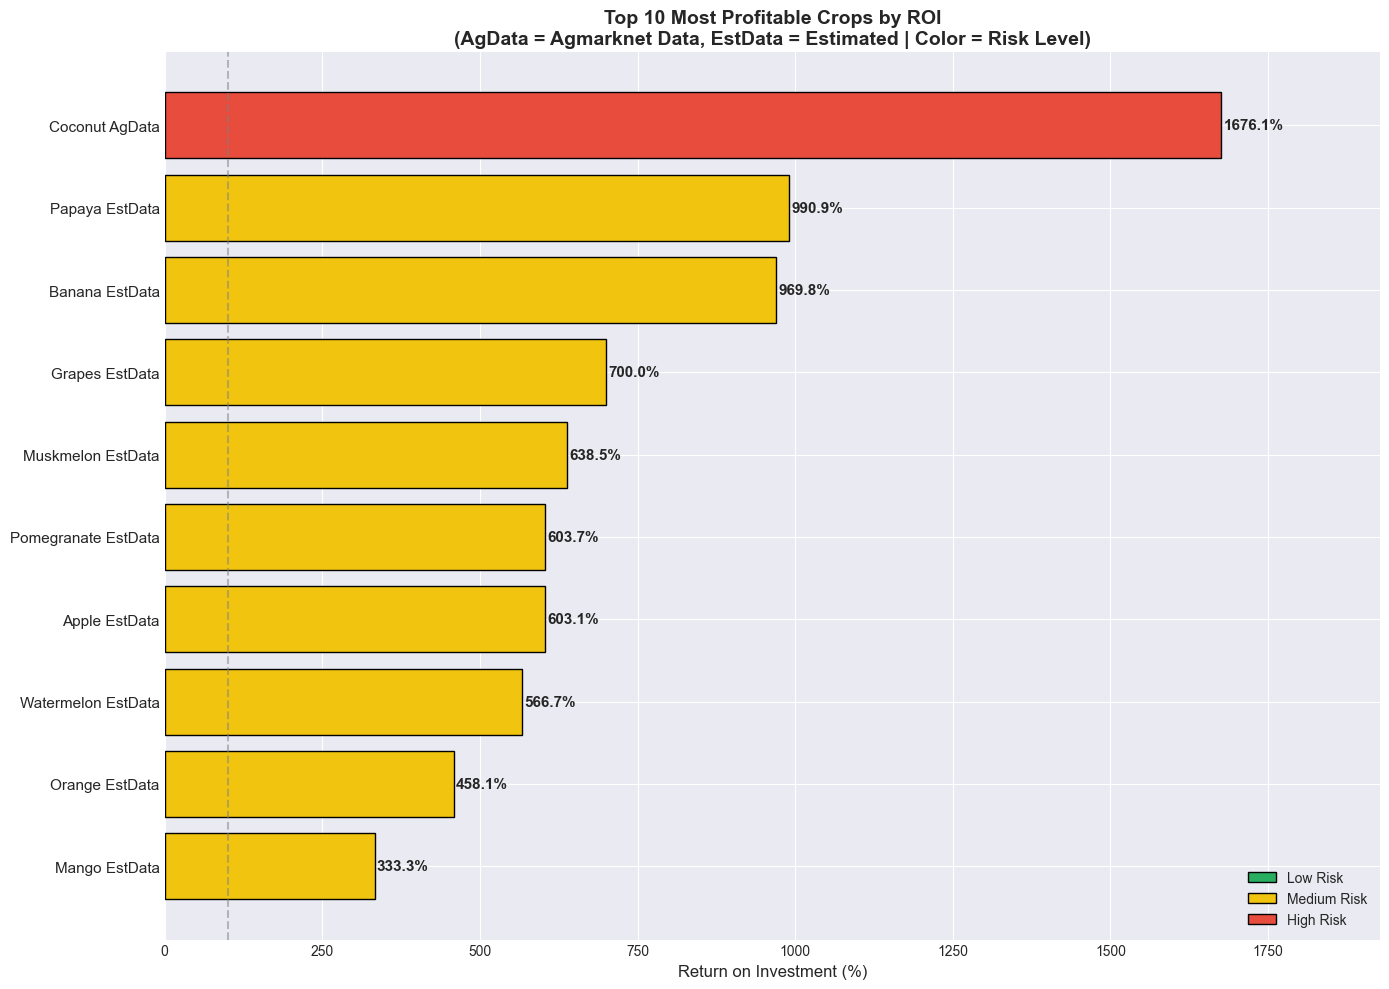

Saved: 56.Top_10_ROI_visualization.png


In [48]:
fig,ax=plt.subplots(figsize=(14,10))
top_10=economic_df.nlargest(10, 'roi').sort_values('roi',ascending=True)

colors_map = {'Low': '#27ae60', 'Medium': '#f1c40f', 'High': '#e74c3c', 'Unknown': '#95a5a6'}
bar_colors = [colors_map.get(cat, '#95a5a6') for cat in top_10['risk_category']]

bars = ax.barh(range(len(top_10)), top_10['roi'], color=bar_colors, 
               edgecolor='black', linewidth=1)

labels = []
for _, row in top_10.iterrows():
    indicator = 'AgData' if row['data_source'] == 'agmarknet' else 'EstData'
    labels.append(f"{row['crop'].title()} {indicator}")

ax.set_yticks(range(len(top_10)))
ax.set_yticklabels(labels, fontsize=11)

# Add value labels
for i, (bar, roi) in enumerate(zip(bars, top_10['roi'])):
    ax.text(bar.get_width() + 3, bar.get_y() + bar.get_height()/2, 
            f'{roi:.1f}%', va='center', fontsize=11, fontweight='bold')

ax.set_xlabel('Return on Investment (%)', fontsize=12)
ax.set_title('Top 10 Most Profitable Crops by ROI\n(AgData = Agmarknet Data, EstData = Estimated | Color = Risk Level)', 
             fontsize=14, fontweight='bold')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#27ae60', edgecolor='black', label='Low Risk'),
    Patch(facecolor='#f1c40f', edgecolor='black', label='Medium Risk'),
    Patch(facecolor='#e74c3c', edgecolor='black', label='High Risk'),
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

ax.axvline(x=100, color='gray', linestyle='--', alpha=0.5, linewidth=1.5)
ax.set_xlim(0, max(top_10['roi']) * 1.15)

plt.tight_layout()
plt.savefig(VIZ_PATH + '56.Top_10_ROI_visualization.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: 56.Top_10_ROI_visualization.png")

Visualization 2- Cost Brekdown

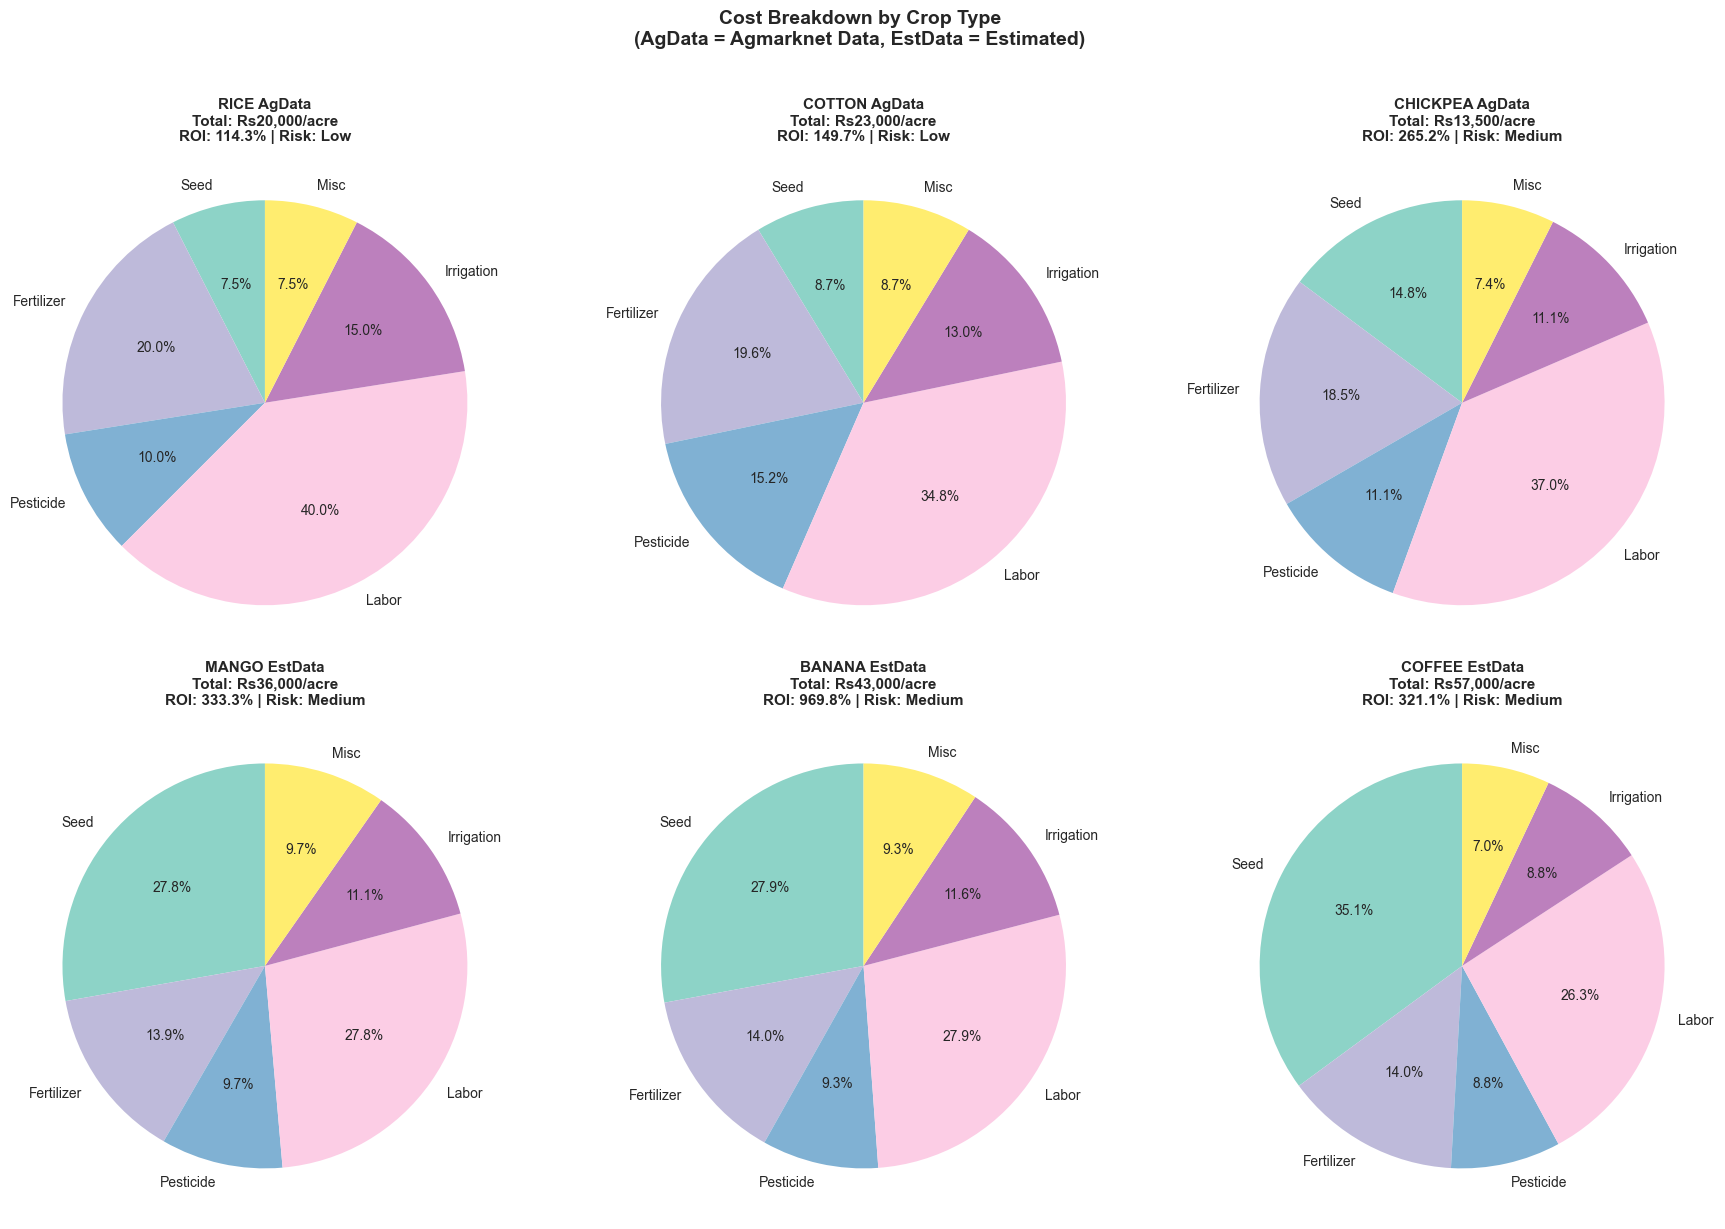

Saved: 57_Cost_breakdown_pie.png


In [49]:
fig,axes=plt.subplots(2,3,figsize=(18,12))
axes=axes.flatten()


sample_crops = ['rice', 'cotton', 'chickpea', 'mango', 'banana', 'coffee']
colors = plt.cm.Set3(np.linspace(0, 1, 6))

for idx,crop in enumerate(sample_crops):
    crop_row=economic_df[economic_df['crop']==crop].iloc[0]
    
    breakdown={
        'Seed': crop_row['seed_cost'],
        'Fertilizer': crop_row['fertilizer_cost'],
        'Pesticide': crop_row['pesticide_cost'],
        'Labor': crop_row['labor_cost'],
        'Irrigation': crop_row['irrigation_cost'],
        'Misc': crop_row['misc_cost']
    }
    
    wedges,texts,autotexts=axes[idx].pie(
        breakdown.values(),
        labels=breakdown.keys(),
        autopct="%1.1f%%",
        colors=colors,
        startangle=90
    )
    
    source_tag = 'AgData' if crop_row['data_source'] == 'agmarknet' else 'EstData'
    axes[idx].set_title(
        f"{crop.upper()} {source_tag}\n"
        f"Total: Rs{crop_row['total_cost']:,.0f}/acre\n"
        f"ROI: {crop_row['roi']:.1f}% | Risk: {crop_row['risk_category']}",
        fontsize=11, fontweight='bold'
    )
    
    plt.suptitle('Cost Breakdown by Crop Type\n(AgData = Agmarknet Data, EstData = Estimated)', 
             fontsize=14, fontweight='bold', y=1.02)
    
plt.tight_layout()
plt.savefig('../data/visualizations/57_Cost_breakdown_pie.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: 57_Cost_breakdown_pie.png")

Visualization 3- Profit vs Risk Scatter

Saved: 58_Profit_vs_Risk_Scatter.png


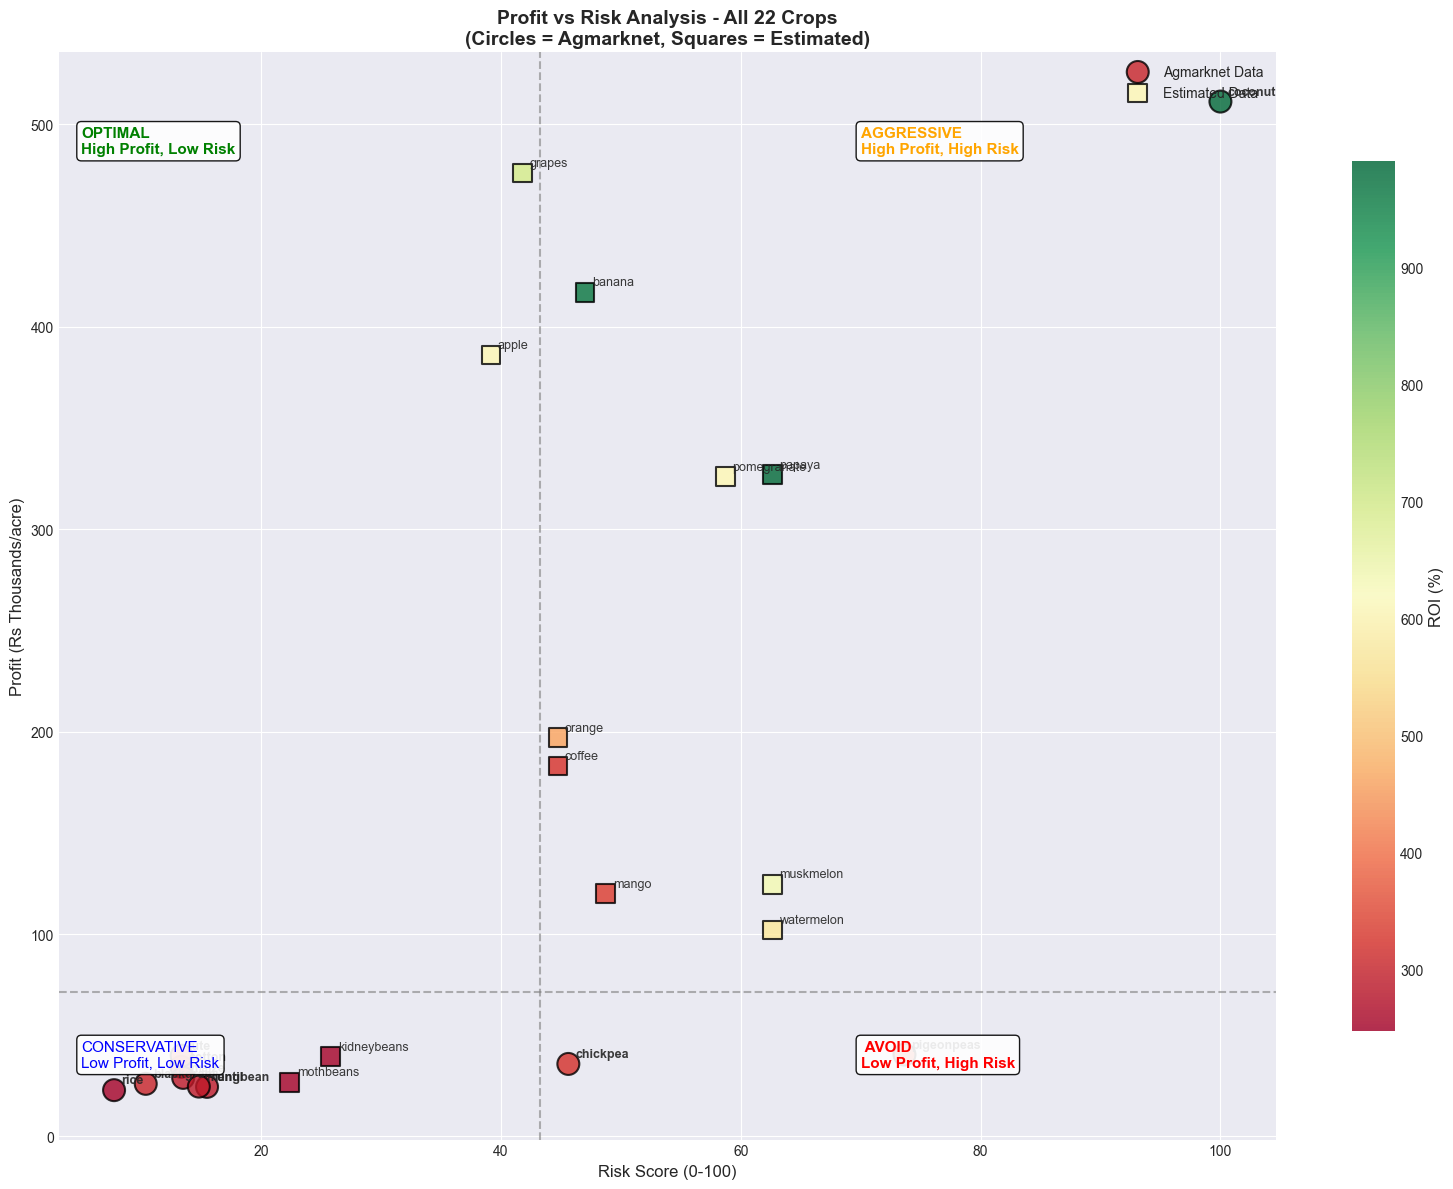

In [75]:
fig, ax = plt.subplots(figsize=(16, 12))

# Separate by data source
for source, marker, size in [('agmarknet', 'o', 250), ('estimated', 's', 180)]:
    mask = economic_df['data_source'] == source
    df_src = economic_df[mask]
    
    scatter = ax.scatter(
        df_src['risk_score'],
        df_src['profit'] / 1000,
        c=df_src['roi'],
        cmap='RdYlGn',
        s=size,
        alpha=0.8,
        edgecolors='black',
        linewidth=1.5,
        marker=marker,
        label=f'{source.title()} Data'
    )

# Colorbar
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
cbar.set_label('ROI (%)', fontsize=12)

# Labels
for _, row in economic_df.iterrows():
    weight = 'bold' if row['data_source'] == 'agmarknet' else 'normal'
    ax.annotate(
        row['crop'],
        (row['risk_score'], row['profit'] / 1000),
        xytext=(5, 5), textcoords='offset points',
        fontsize=9, fontweight=weight, alpha=0.9
    )

# Quadrant lines
median_risk = economic_df['risk_score'].median()
median_profit = economic_df['profit'].median() / 1000
ax.axvline(x=median_risk, color='gray', linestyle='--', alpha=0.6)
ax.axhline(y=median_profit, color='gray', linestyle='--', alpha=0.6)

# Quadrant labels
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
ax.text(5, economic_df['profit'].max() / 1000 * 0.95, 
        'OPTIMAL\nHigh Profit, Low Risk', 
        fontsize=11, color='green', fontweight='bold', bbox=props)
ax.text(economic_df['risk_score'].max() * 0.7, economic_df['profit'].max() / 1000 * 0.95,
        'AGGRESSIVE\nHigh Profit, High Risk', 
        fontsize=11, color='orange', fontweight='bold', bbox=props)
ax.text(5, economic_df['profit'].min() / 1000 * 1.5,
        'CONSERVATIVE\nLow Profit, Low Risk', 
        fontsize=11, color='blue', bbox=props)
ax.text(economic_df['risk_score'].max() * 0.7, economic_df['profit'].min() / 1000 * 1.5,
        ' AVOID\nLow Profit, High Risk', 
        fontsize=11, color='red', fontweight='bold', bbox=props)

ax.set_xlabel('Risk Score (0-100)', fontsize=12)
ax.set_ylabel('Profit (Rs Thousands/acre)', fontsize=12)
ax.set_title('Profit vs Risk Analysis - All 22 Crops\n(Circles = Agmarknet, Squares = Estimated)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right')


plt.tight_layout()
plt.savefig('../data/visualizations/58_Profit_vs_Risk_Scatter.png', dpi=300, bbox_inches='tight')
print("Saved: 58_Profit_vs_Risk_Scatter.png")
plt.show()

Visualization Price Volatility

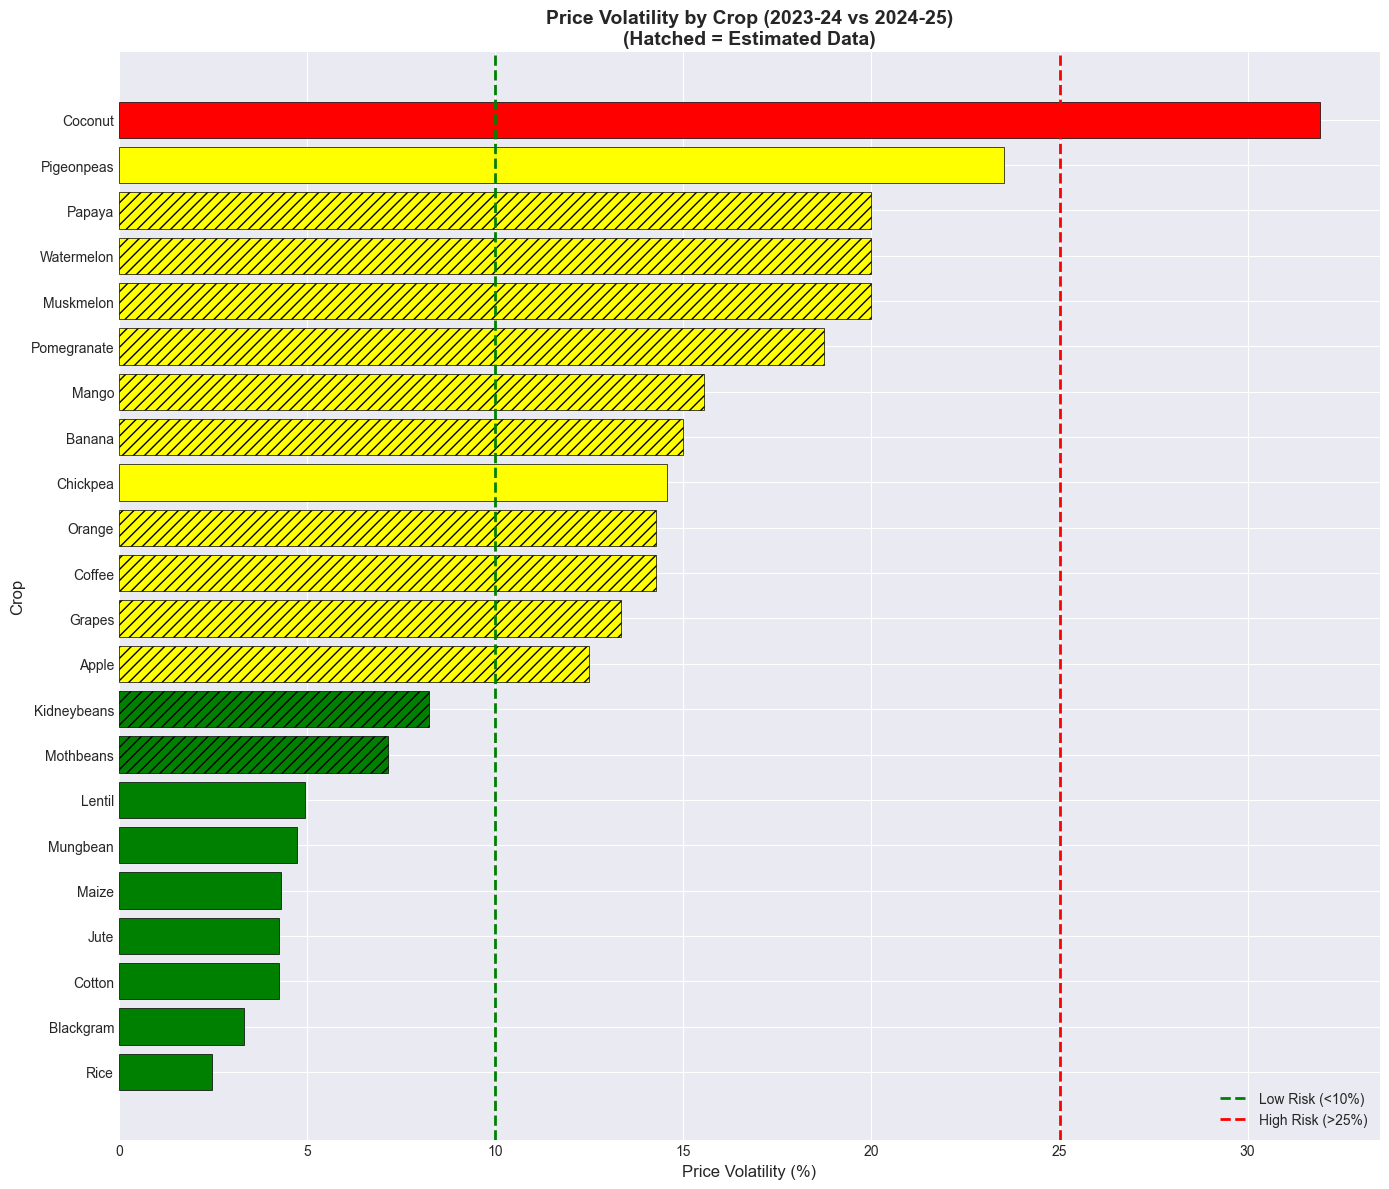

✅ Saved: 59_volatility_visualization.png


In [51]:
fig,ax=plt.subplots(figsize=(14,12))

sorted_df = economic_df.sort_values('volatility', ascending=True)

colors_map = {'Low': 'green', 'Medium': 'yellow', 'High': 'red'}
bar_colors = [colors_map.get(cat, '#95a5a6') for cat in sorted_df['risk_category']]

hatches = ['' if src == 'agmarknet' else '///' for src in sorted_df['data_source']]

bars = ax.barh(range(len(sorted_df)), sorted_df['volatility'], color=bar_colors, 
               edgecolor='black', linewidth=0.5)

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

ax.set_yticks(range(len(sorted_df)))
ax.set_yticklabels(sorted_df['crop'].str.title())
ax.axvline(x=10, color='green', linestyle='--', linewidth=2, label='Low Risk (<10%)')
ax.axvline(x=25, color='red', linestyle='--', linewidth=2, label='High Risk (>25%)')

ax.set_xlabel('Price Volatility (%)', fontsize=12)
ax.set_ylabel('Crop', fontsize=12)
ax.set_title('Price Volatility by Crop (2023-24 vs 2024-25)\n(Hatched = Estimated Data)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig('../data/visualizations/59_volatility_visualization.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: 59_volatility_visualization.png")

Visualization For Dashboard

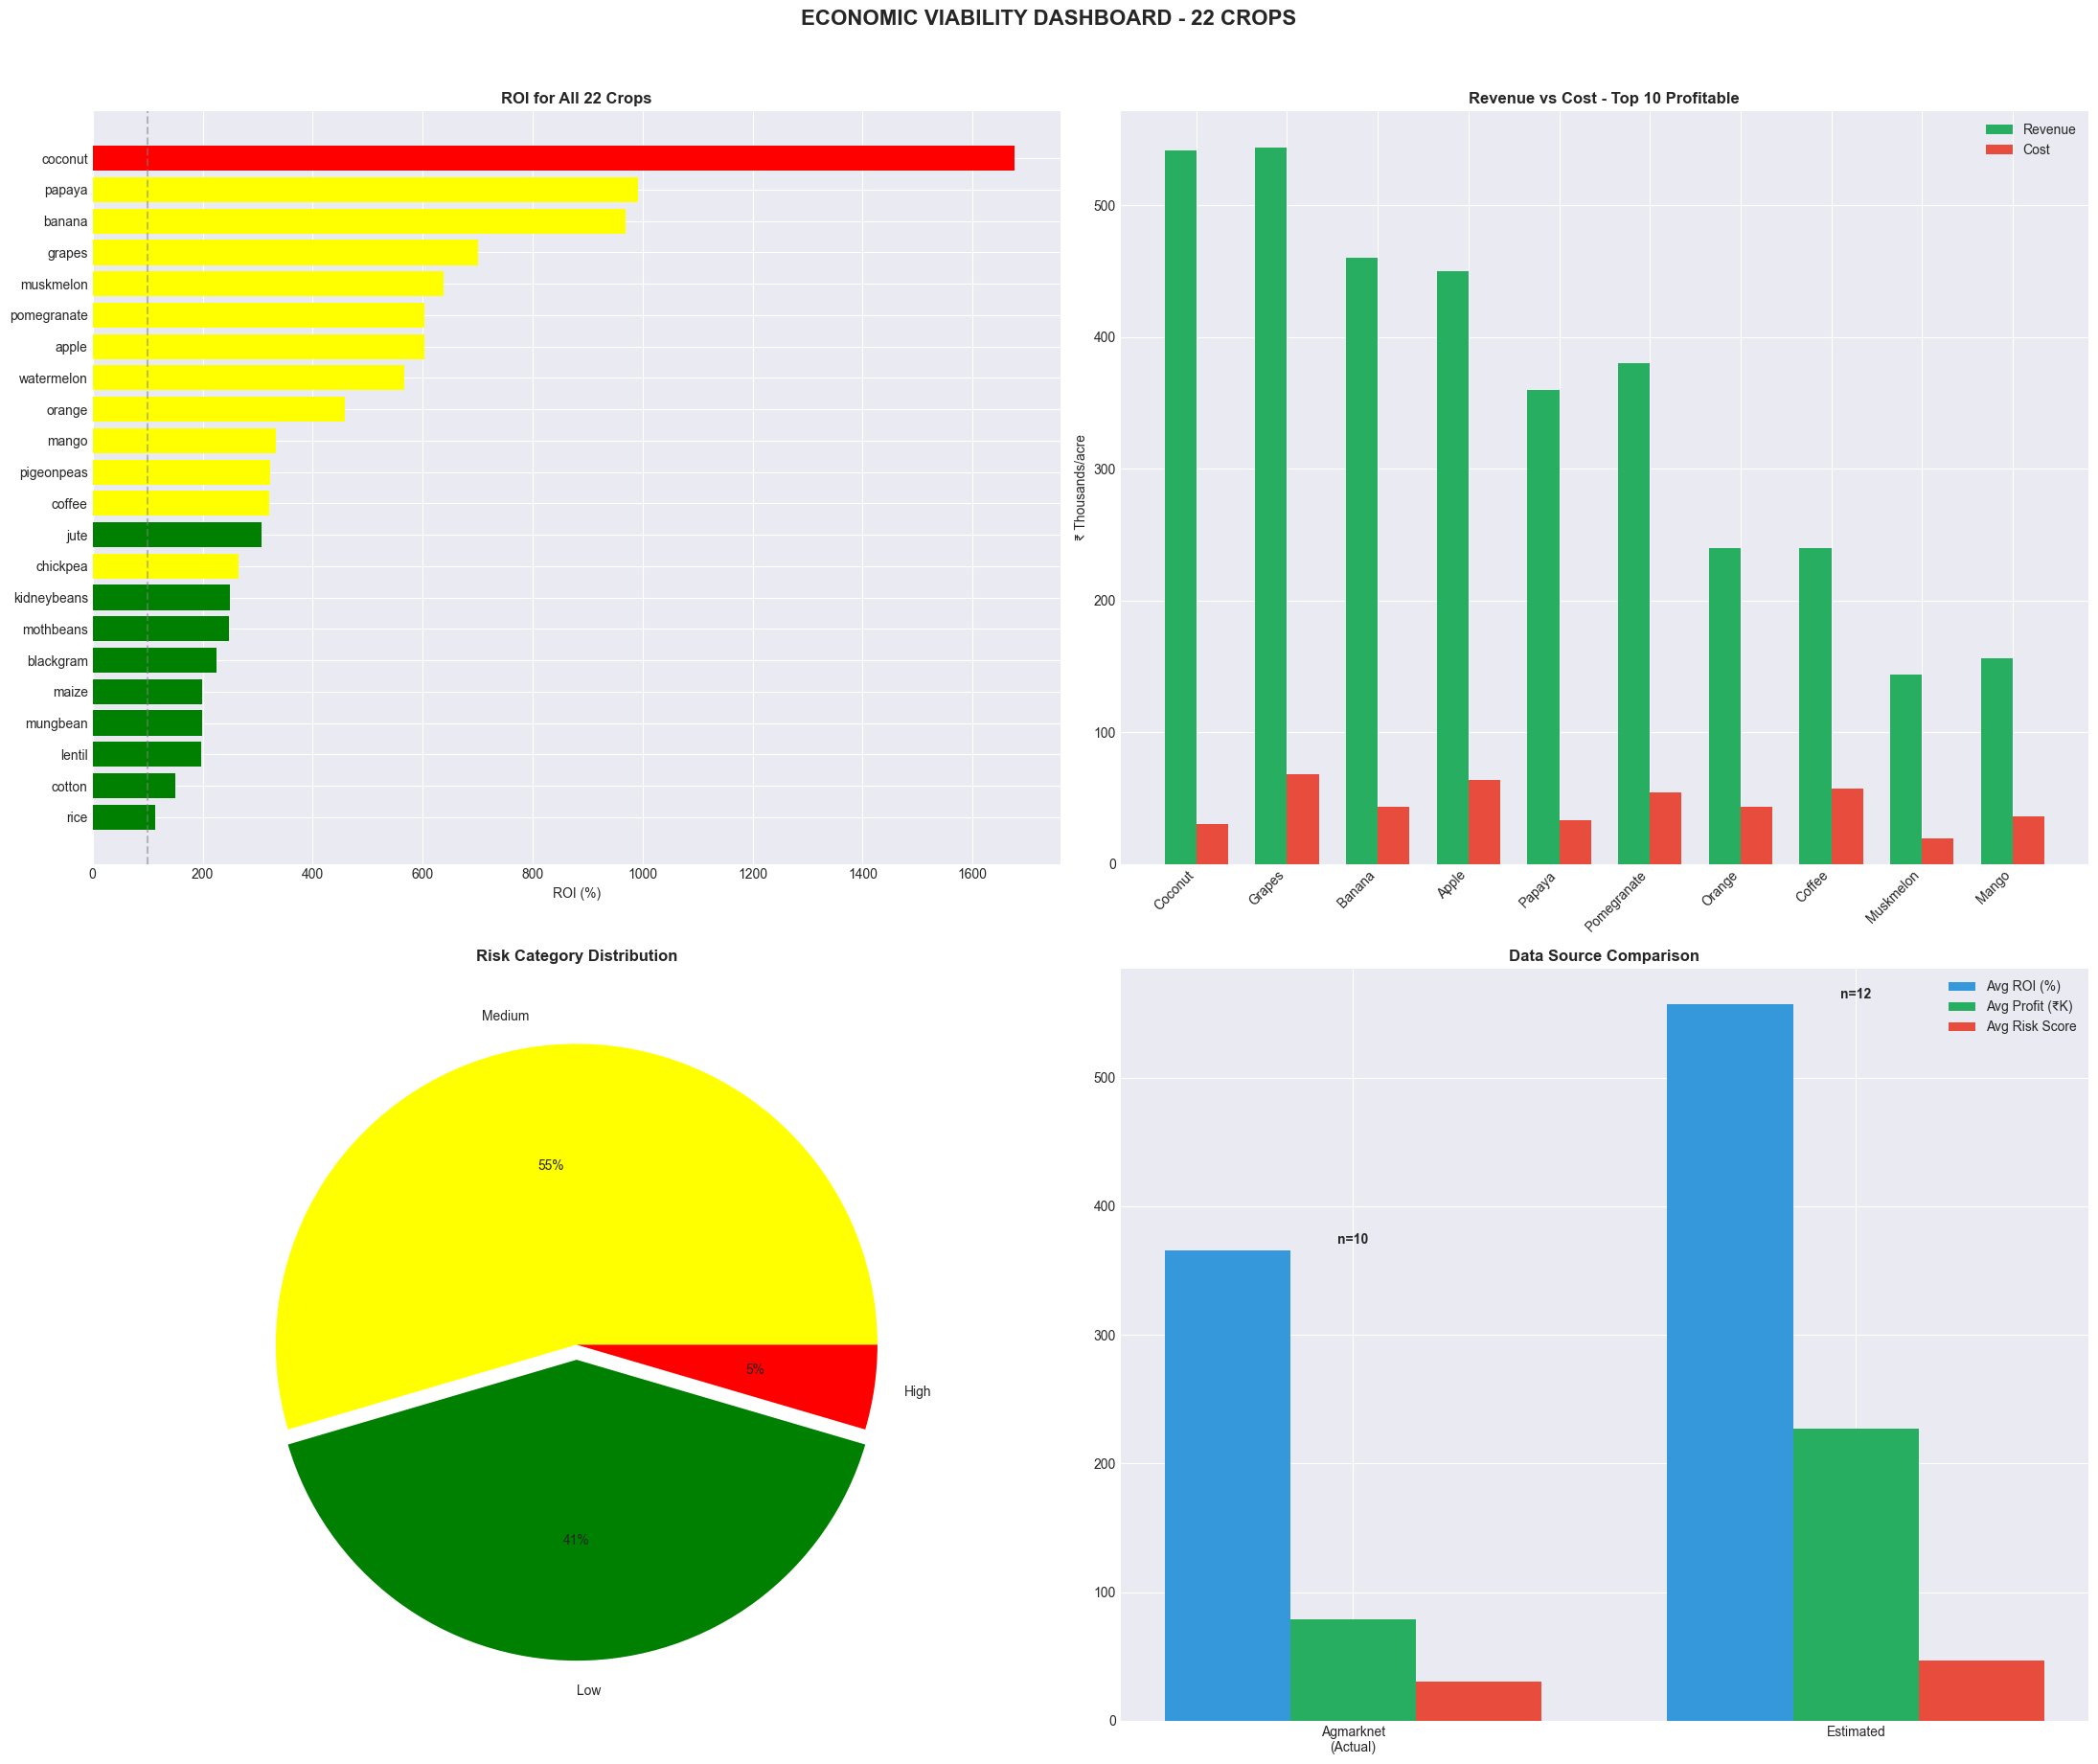

Saved: 60_Economic_Dashboard.png


In [52]:
fig = plt.figure(figsize=(22, 18))

# 1. All crops ROI
ax1 = fig.add_subplot(2, 2, 1)
sorted_roi = economic_df.sort_values('roi', ascending=True)
colors = [colors_map.get(cat, 'cadetgrey') for cat in sorted_roi['risk_category']]
ax1.barh(sorted_roi['crop'], sorted_roi['roi'], color=colors)
ax1.set_xlabel('ROI (%)')
ax1.set_title('ROI for All 22 Crops', fontweight='bold')
ax1.axvline(x=100, color='gray', linestyle='--', alpha=0.5)

# 2. Revenue vs Cost (Top 10)
ax2 = fig.add_subplot(2, 2, 2)
top_profit = economic_df.nlargest(10, 'profit')
x = np.arange(len(top_profit))
width = 0.35
ax2.bar(x - width/2, top_profit['revenue']/1000, width, label='Revenue', color='#27ae60')
ax2.bar(x + width/2, top_profit['total_cost']/1000, width, label='Cost', color='#e74c3c')
ax2.set_xticks(x)
ax2.set_xticklabels(top_profit['crop'].str.title(), rotation=45, ha='right')
ax2.set_ylabel('₹ Thousands/acre')
ax2.set_title('Revenue vs Cost - Top 10 Profitable', fontweight='bold')
ax2.legend()

# 3. Risk Distribution
ax3 = fig.add_subplot(2, 2, 3)
risk_counts = economic_df['risk_category'].value_counts()
colors_pie = [colors_map.get(cat, 'cadetgrey') for cat in risk_counts.index]
ax3.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.0f%%',
        colors=colors_pie, explode=[0.05 if cat == 'Low' else 0 for cat in risk_counts.index])
ax3.set_title('Risk Category Distribution', fontweight='bold')

# 4. Data Source Comparison
ax4 = fig.add_subplot(2, 2, 4)
source_summary = economic_df.groupby('data_source').agg({
    'roi': 'mean',
    'profit': 'mean',
    'risk_score': 'mean',
    'crop': 'count'
}).round(2)

x = np.arange(len(source_summary))
width = 0.25
ax4.bar(x - width, source_summary['roi'], width, label='Avg ROI (%)', color='#3498db')
ax4.bar(x, source_summary['profit']/1000, width, label='Avg Profit (₹K)', color='#27ae60')
ax4.bar(x + width, source_summary['risk_score'], width, label='Avg Risk Score', color='#e74c3c')
ax4.set_xticks(x)
ax4.set_xticklabels(['Agmarknet\n(Actual)', 'Estimated'])
ax4.set_title('Data Source Comparison', fontweight='bold')
ax4.legend()

for i, count in enumerate(source_summary['crop']):
    ax4.text(i, source_summary['roi'].iloc[i] + 5, f'n={int(count)}', ha='center', fontweight='bold')

plt.suptitle('ECONOMIC VIABILITY DASHBOARD - 22 CROPS', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../data/visualizations/60_Economic_Dashboard.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: 60_Economic_Dashboard.png")

MSP vs Market Price (Agmarknet only)

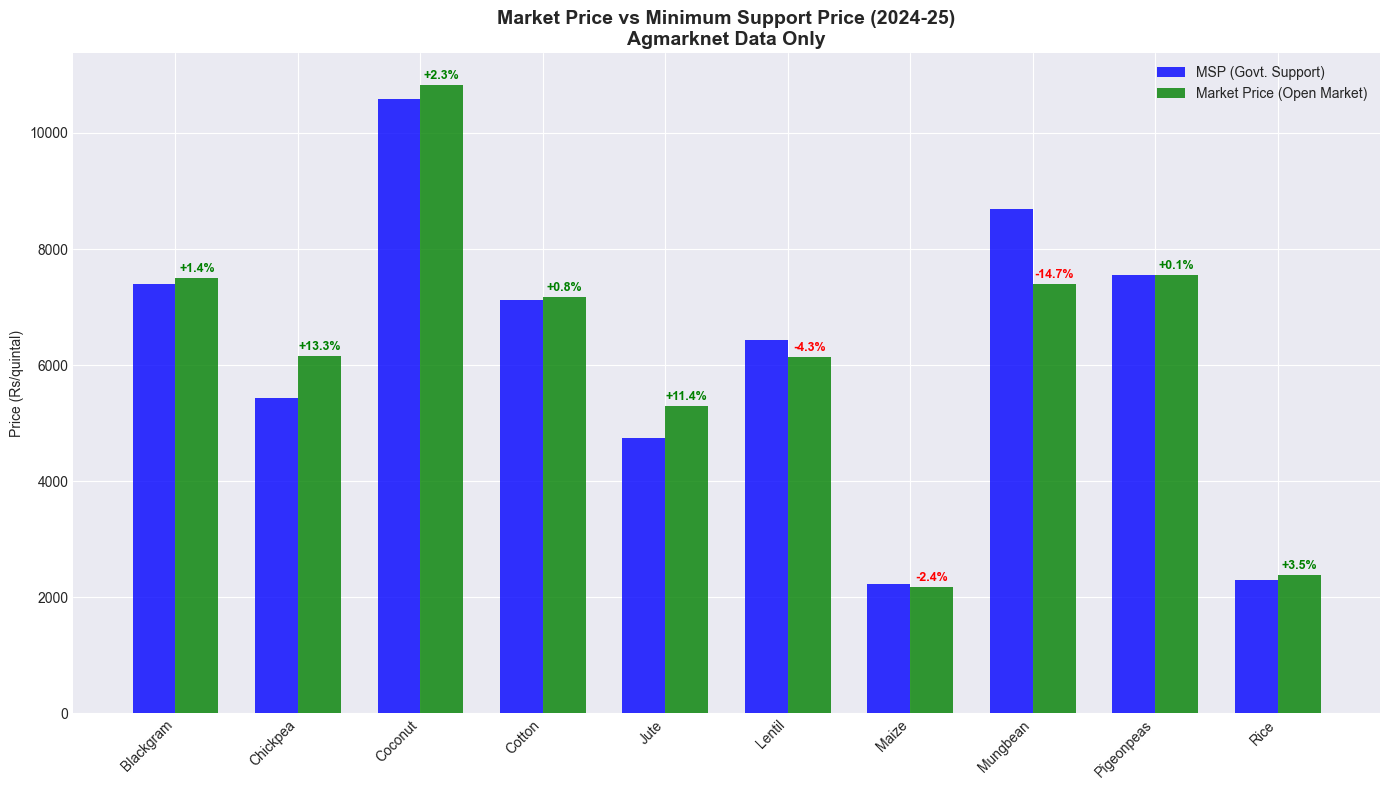

✅ Saved: 61.MSP_comparison.png


In [53]:
fig,ax=plt.subplots(figsize=(14,8))

msp_crops = economic_df[(economic_df['msp_2024'] > 0) & (economic_df['data_source'] == 'agmarknet')]

if len(msp_crops) > 0:
    x = np.arange(len(msp_crops))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, msp_crops['msp_2024'], width, 
                   label='MSP (Govt. Support)', color='blue', alpha=0.8)
    bars2 = ax.bar(x + width/2, msp_crops['price_2024'], width, 
                   label='Market Price (Open Market)', color='green', alpha=0.8)
    
    ax.set_xticks(x)
    ax.set_xticklabels(msp_crops['crop'].str.title(), rotation=45, ha='right')
    ax.set_ylabel('Price (Rs/quintal)')
    ax.set_title('Market Price vs Minimum Support Price (2024-25)\nAgmarknet Data Only', 
                 fontsize=14, fontweight='bold')
    ax.legend()
    
    # Difference labels
    for i, (bar1, bar2, crop) in enumerate(zip(bars1, bars2, msp_crops['crop'])):
        diff = bar2.get_height() - bar1.get_height()
        diff_pct = (diff / bar1.get_height()) * 100
        color = 'green' if diff > 0 else 'red'
        ax.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 100,
                f'{diff_pct:+.1f}%', ha='center', fontsize=9, color=color, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/visualizations/61.MSP_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: 61.MSP_comparison.png")

ROI VS RISK QUADRANT

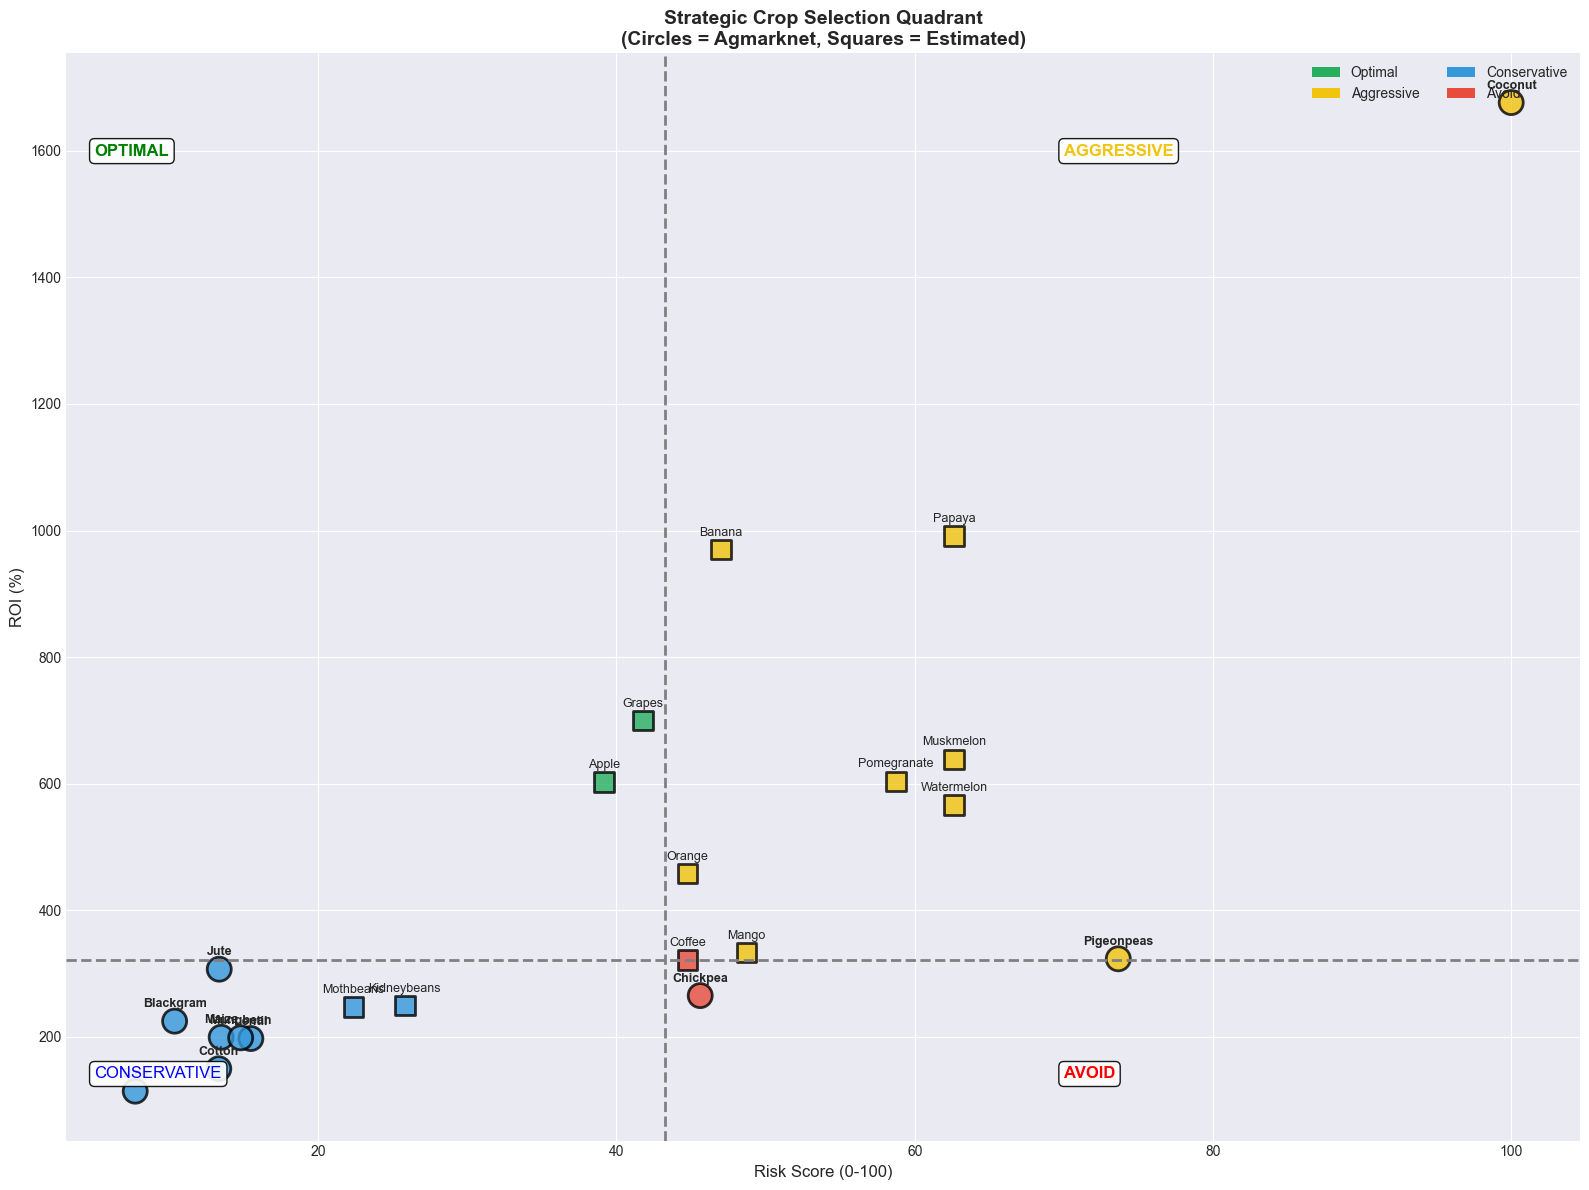

Saved: 62_ROI_vs_RISK_quadrant.png


In [57]:
fig,ax=plt.subplots(figsize=(16,12))

median_roi=economic_df['roi'].median()
median_risk=economic_df['risk_score'].median()

def get_quadrant_color(row):
    if row['roi'] >= median_roi and row['risk_score'] < median_risk:
        return '#27ae60'  # Best
    elif row['roi'] >= median_roi:
        return '#f1c40f'  # Aggressive
    elif row['risk_score'] < median_risk:
        return '#3498db'  # Conservative
    else:
        return '#e74c3c'  # Avoid

colors=economic_df.apply(get_quadrant_color, axis=1)

for source, marker in [('agmarknet', 'o'), ('estimated', 's')]:
    mask = economic_df['data_source'] == source
    size = 300 if source == 'agmarknet' else 200
    ax.scatter(economic_df[mask]['risk_score'], economic_df[mask]['roi'],
               c=colors[mask], s=size, alpha=0.8, edgecolors='black',
               linewidth=2, marker=marker, label=f'{source.title()} Data')

for _, row in economic_df.iterrows():
    weight = 'bold' if row['data_source'] == 'agmarknet' else 'normal'
    ax.annotate(row['crop'].title(), (row['risk_score'], row['roi']),
                xytext=(0, 10), textcoords='offset points',
                fontsize=9, ha='center', fontweight=weight)
    
ax.axvline(x=median_risk, color='gray', linestyle='--', linewidth=2)
ax.axhline(y=median_roi, color='gray', linestyle='--', linewidth=2)


props = dict(boxstyle='round', facecolor='white', alpha=0.9)
ax.text(5, economic_df['roi'].max() * 0.95, 'OPTIMAL', fontsize=12, color='green', fontweight='bold', bbox=props)
ax.text(economic_df['risk_score'].max() * 0.7, economic_df['roi'].max() * 0.95,'AGGRESSIVE', fontsize=12, color='#f1c40f', fontweight='bold', bbox=props)
ax.text(5, economic_df['roi'].min() + 20, 'CONSERVATIVE',  fontsize=12, color='blue', bbox=props)
ax.text(economic_df['risk_score'].max() * 0.7, economic_df['roi'].min() + 20,'AVOID', fontsize=12, color='red', fontweight='bold', bbox=props)

ax.set_xlabel('Risk Score (0-100)', fontsize=12)
ax.set_ylabel('ROI (%)', fontsize=12)
ax.set_title('Strategic Crop Selection Quadrant\n(Circles = Agmarknet, Squares = Estimated)', 
             fontsize=14, fontweight='bold')


legend_elements = [
    Patch(facecolor='#27ae60', label='Optimal'),
    Patch(facecolor='#f1c40f', label='Aggressive'),
    Patch(facecolor='#3498db', label='Conservative'),
    Patch(facecolor='#e74c3c', label='Avoid'),
]
ax.legend(handles=legend_elements, loc='upper right', ncol=2)

plt.tight_layout()
plt.savefig('../data/visualizations/62_ROI_vs_RISK_quadrant.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: 62_ROI_vs_RISK_quadrant.png")

# Export Results

In [59]:
economic_df.to_csv('../data/results/economic_analysis.csv', index=False)
print(f"Saved: economic_analysis.csv")

Saved: economic_analysis.csv


In [ ]:
ranking = economic_df.sort_values('profitability_rank')[
    ['profitability_rank', 'crop', 'commodity_group', 'season', 'data_source',
     'price_2024', 'roi', 'profit', 'risk_category', 'risk_score']
]
ranking.to_csv('../data/results/profitability_ranking.csv', index=False)
print("Saved: profitability_ranking.csv")

Saved: profitability_ranking.csv


In [ ]:
risk_df = economic_df[['crop', 'price_2023', 'price_2024', 'price_change_pct',
                        'volatility', 'risk_score', 'risk_category', 'data_source']].sort_values('risk_score')
risk_df.to_csv('../data/visualizations/risk_analysis.csv', index=False)
print("Saved: risk_analysis.csv")

Saved: risk_analysis.csv


In [63]:
price_db.to_csv('../data/visualizations/processed_price_data.csv', index=False)
print("Saved: processed_price_data.csv")

Saved: processed_price_data.csv


In [64]:
crop_stats.to_csv('../data/visualizations/crop_statistics.csv', index=False)
print("Saved: crop_statistics.csv")

Saved: crop_statistics.csv


In [65]:
summary = {
    'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'total_crops': len(economic_df),
    'agmarknet_crops': len(economic_df[economic_df['data_source'] == 'agmarknet']),
    'estimated_crops': len(economic_df[economic_df['data_source'] == 'estimated']),
    'avg_roi': round(economic_df['roi'].mean(), 2),
    'max_roi': round(economic_df['roi'].max(), 2),
    'min_roi': round(economic_df['roi'].min(), 2),
    'avg_profit': round(economic_df['profit'].mean(), 2),
    'low_risk_count': len(economic_df[economic_df['risk_category'] == 'Low']),
    'medium_risk_count': len(economic_df[economic_df['risk_category'] == 'Medium']),
    'high_risk_count': len(economic_df[economic_df['risk_category'] == 'High']),
    'most_profitable': economic_df.loc[economic_df['roi'].idxmax(), 'crop'],
    'safest_profitable': economic_df[economic_df['risk_category'] == 'Low'].nlargest(1, 'roi')['crop'].values[0] if len(economic_df[economic_df['risk_category'] == 'Low']) > 0 else 'N/A'
}

In [66]:
pd.DataFrame([summary]).to_csv('../data/results/economic_summary.csv', index=False)
print("Saved: economic_summary.csv")

Saved: economic_summary.csv


In [67]:
class EconomicAnalyzer:
    
    def __init__(self, economic_data, price_data, yield_data, cost_data, crop_stats):
        self.economic_data = economic_data
        self.price_data = price_data
        self.yield_data = yield_data
        self.cost_data = cost_data
        self.crop_stats = crop_stats
        self.crops = economic_data['crop'].tolist()
    
    def get_crop_economics(self, crop_name):
        crop_name = crop_name.lower().strip()
        row = self.economic_data[self.economic_data['crop'] == crop_name]
        if len(row) == 0:
            return {'error': f"Crop '{crop_name}' not found"}
        
        row = row.iloc[0]
        return {
            'crop': crop_name,
            'season': row['season'],
            'data_source': row['data_source'],
            'commodity_group': row['commodity_group'],
            'price_2024': row['price_2024'],
            'msp_2024': row['msp_2024'],
            'yield_per_acre': row['yield_per_acre'],
            'total_cost': row['total_cost'],
            'revenue': row['revenue'],
            'profit': row['profit'],
            'roi': row['roi'],
            'profit_margin': row['profit_margin'],
            'break_even_yield': row['break_even_yield'],
            'risk_score': row['risk_score'],
            'risk_category': row['risk_category'],
            'volatility': row['volatility'],
            'profitability_rank': int(row['profitability_rank']),
            'costs': {
                'seed': row['seed_cost'],
                'fertilizer': row['fertilizer_cost'],
                'pesticide': row['pesticide_cost'],
                'labor': row['labor_cost'],
                'irrigation': row['irrigation_cost'],
                'misc': row['misc_cost']
            }
        }
    
    def compare_crops(self, crop_list):
        return self.economic_data[self.economic_data['crop'].isin([c.lower() for c in crop_list])].to_dict('records')
    
    def rank_by_profitability(self, n=10):
        return self.economic_data.nlargest(n, 'roi')[['crop', 'roi', 'profit', 'risk_category', 'data_source']].to_dict('records')
    
    def get_recommendation_with_economics(self, predicted_crops, probabilities):
        recs = []
        for crop, prob in zip(predicted_crops, probabilities):
            econ = self.get_crop_economics(crop)
            if 'error' in econ:
                continue
            
            ml_score = prob * 100
            roi_score = min(econ['roi'] / 2, 50)
            risk_penalty = econ['risk_score'] / 5
            overall = ml_score * 0.5 + roi_score * 0.4 - risk_penalty
            
            recs.append({
                'crop': crop,
                'ml_confidence': round(prob * 100, 2),
                'roi': econ['roi'],
                'profit': econ['profit'],
                'risk_category': econ['risk_category'],
                'overall_score': round(overall, 2),
                'season': econ['season'],
                'data_source': econ['data_source']
            })
        
        return sorted(recs, key=lambda x: x['overall_score'], reverse=True)

In [68]:
analyzer = EconomicAnalyzer(economic_df, price_db, yield_data, cost_data, crop_stats)

In [69]:
with open('../models/economic_analyzer.pkl', 'wb') as f:
    pickle.dump(analyzer, f)

print(f"Saved: economic_analyzer.pkl")

Saved: economic_analyzer.pkl


In [77]:
print(f"""
ANALYSIS OVERVIEW
Total Crops:              {summary['total_crops']}
  └─ Agmarknet (Actual):  {summary['agmarknet_crops']}
  └─ Estimated:           {summary['estimated_crops']}

PROFITABILITY METRICS
Average ROI:              {summary['avg_roi']}%
Maximum ROI:              {summary['max_roi']}%
Minimum ROI:              {summary['min_roi']}%
Average Profit:           ₹{summary['avg_profit']:,.0f}/acre

RISK DISTRIBUTION

Low Risk:                 {summary['low_risk_count']} crops
Medium Risk:              {summary['medium_risk_count']} crops
High Risk:                {summary['high_risk_count']} crops

TOP RECOMMENDATIONS
Most Profitable:          {summary['most_profitable'].upper()}
Safest Investment:        {summary['safest_profitable'].upper()}

""")



ANALYSIS OVERVIEW
Total Crops:              22
  └─ Agmarknet (Actual):  10
  └─ Estimated:           12

PROFITABILITY METRICS
Average ROI:              469.9%
Maximum ROI:              1676.12%
Minimum ROI:              114.31%
Average Profit:           ₹159,693/acre

RISK DISTRIBUTION

Low Risk:                 9 crops
Medium Risk:              12 crops
High Risk:                1 crops

TOP RECOMMENDATIONS
Most Profitable:          COCONUT
Safest Investment:        JUTE


